In [1]:
# Importing libraries
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pymaster as nmt

In [5]:
#Read the map
Planck_SMICA=hp.read_map('/home/akozameh/COM_CMB_IQU-smica_2048_R3.00_hm2.fits')

Since we are interested in large-angular scale, the maps were degraded at NSIDE = 64 and NSIDE=16

In [7]:
#Planck SMICA degraded map
Planck_1=hp.pixelfunc.ud_grade(Planck_SMICA, 64)       #degraded maps at NSIDE=64
Planck_2=hp.pixelfunc.ud_grade(Planck_SMICA, 16)       #degraded maps at NSIDE=16

In [51]:
# Creating new mask in equatorial coordinates
NSIDE = 64
ipix=hp.nside2npix(NSIDE)
m=np.zeros(ipix) #mask


type(ipix)

int

In [124]:
# I make a list of thetas and phi 
thetas=[]
phis=[]
for j in range(0,(ipix)):
    theta,phi=(hp.pix2ang(NSIDE, j))
    thetas.append(theta)
    phis.append(phi)


In [125]:
# it makes theta and phi array by numpy array
theta_a=np.array(thetas)
phis_a=np.array(phis)

In [126]:
phis_a

array([0.78539816, 2.35619449, 3.92699082, ..., 2.35619449, 3.92699082,
       5.49778714])

In [127]:
# Converting the theta, phi in r.a and decl.
decl=np.rad2deg(0.5 * np.pi - theta_a)
ra = np.rad2deg(phis_a)

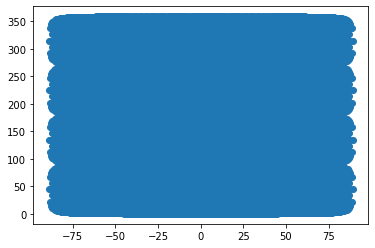

In [129]:
plt.scatter(decl,ra)

In [164]:
# Selecting the survey class
clas1=np.where(decl>-70)# and decl<=30)
clas2=np.where(decl<30)
clas3=clas1 & clas2
#clas=clas1 clas2

TypeError: unsupported operand type(s) for &: 'tuple' and 'tuple'

In [158]:
cond1 = decl>-70
cond2 = decl<30
mask  = cond1 & cond2

In [161]:
type(mask)

numpy.ndarray

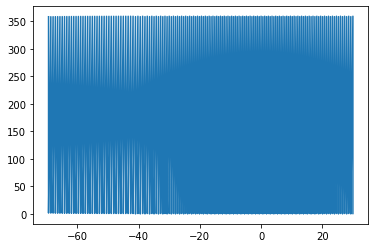

In [160]:
plt.plot(decl[mask],ra[mask])

In [173]:
# Convert the decl and r.a in theta and phi
theta = 0.5 * np.pi - np.deg2rad(decl[mask])
phi = np.deg2rad(ra[mask])


In [172]:
# It Converts theta and phi in number of pixeles
pix=hp.ang2pix(NSIDE,theta,phi)
pix

array([12160, 12161, 12162, ..., 47637, 47638, 47639])

In [175]:
m[pix]=1

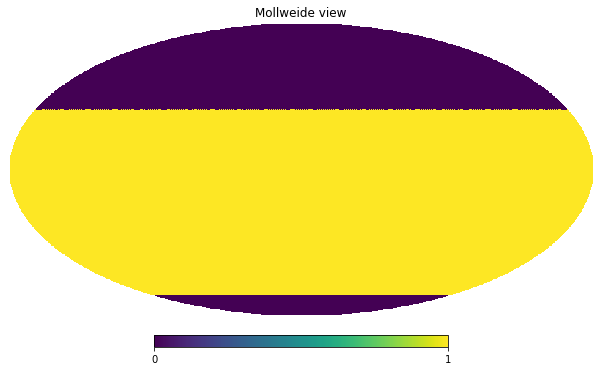

In [176]:
hp.mollview(m)

In [179]:
rot=hp.Rotator(coord=['C','G'])  # Transforms equatorial to galactic coordinates